In [107]:
# Python API Homework - Part I - WeatherPy
# UT-TOR-DATA-PT-01-2020-U-C Assignment #6
# (c) Boris Smirnov

# WeatherPy
----

In [154]:
%matplotlib notebook

In [128]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Cities data from citipy module
input_data_file = '../Resources/worldcities.csv'

# Output File (CSV)
output_data_file = "../output_data/cities.csv"

# Base OpenWeather URL
weather_url = f"https://api.openweathermap.org/data/2.5/weather?appid={weather_api_key}&units=metric"

In [129]:
# I'm not going to generate random coordinates and search for the nearest city.
# 71% of Earth's surface is covered by oceans. Theoretically, 71% of uniformely distributed random coordinates would
# be in the World Ocean, thus the nearest cities to that coordinates would be on the coast line, which definitely affects
# further analysis.
# I'm going to use worldcities.csv that came with citipy module and (almost) randomly pick cities from there.
# For that purpose, the first thing to do is to check cities distribution by parallels

cities_df = pd.read_csv(input_data_file)

# P.S.
# City name is a bad key: there are cities with the same name even in a single country
# More then 4000 cities have namesakes, that is significant 10% of the dataset
# Coordinates are better, especially when OpenWeather API allows query by coordinates, not only by (city,country)

# Total cities   Total unique city names by country                      Total unique city names worldwide
(len(cities_df), len(cities_df.groupby(by=['Country', 'City']).count()), len(cities_df['City'].unique()))

(46832, 43864, 42105)

In [130]:
# How cities are distributed by latitude?
latitude_bins = [lat for lat in range(-90, 100, 10)]
cities_df['Belt'] = pd.cut(cities_df['Latitude'], latitude_bins)
cities_df['Belt'].value_counts(sort=False)

(-90, -80]        0
(-80, -70]        0
(-70, -60]        0
(-60, -50]        3
(-50, -40]       91
(-40, -30]      448
(-30, -20]     1519
(-20, -10]     1119
(-10, 0]       1759
(0, 10]        3660
(10, 20]       6594
(20, 30]       3777
(30, 40]       5485
(40, 50]      13950
(50, 60]       7581
(60, 70]        816
(70, 80]         30
(80, 90]          0
Name: Belt, dtype: int64

In [131]:
# Redistribution of cities by "belts"
# I'll sample 50 cities per "belt", giving required >500 cities for further analysis
new_latitude_bins = [-90] + [lat for lat in range(-30, 70, 10)] + [90]
cities_df['Belt'] = pd.cut(cities_df['Latitude'], new_latitude_bins)
cities_df['Belt'].value_counts(sort=False)

(-90, -30]      542
(-30, -20]     1519
(-20, -10]     1119
(-10, 0]       1759
(0, 10]        3660
(10, 20]       6594
(20, 30]       3777
(30, 40]       5485
(40, 50]      13950
(50, 60]       7581
(60, 90]        846
Name: Belt, dtype: int64

In [147]:
# Check if we already have city weather data. If not, get it from OpenWeather. Otherwise, skip the next step
try:
    sample_cities_df = pd.read_csv(output_data_file) # no file -> exception
    if sample_cities_df.count() < 500:               # not enough data -> exception
        raise Exception("Not enough data.")
    belts = []                                       # already have data -> skip the for-loop below
    print(f"Weather data read from existing {output_data_file}. No data retrieval necessary")
except: # no or not enough data - initialize, and proceed to the for-loop below
    belts = cities_df['Belt'].unique()
    sample_cities_df = pd.DataFrame()

Beginning data retrieval:


In [148]:
# Fill sample_cities_df DataFrame with sample cities data augmented with Weather data
for belt in belts:

    print(f"=== Retrieving data for cities in {belt} =============================================")
    
    # In case OpenWeather doesn't have info for a given location, I'll give 10% slack on try count
    tries_count = 0
    city_count = 0
    
    while (city_count < 50) & (tries_count < 55):
        sample_city = cities_df.loc[cities_df['Belt'] == belt].sample(1)
        city_idx = sample_city.index[0]
        city_dct = sample_city.iloc[0,:].to_dict()

        # Handle city collision: just try another one - there are plenty in every latitude belt
        if city_idx in sample_cities_df.index:
            continue
        else:
            tries_count +=1

        try:
            print(f"Latitudes:{belt}\tTry:{tries_count}/55\tCity:{city_count}/50\t{city_dct['Country']},{city_dct['City']}:\t\t", end='', flush=True)
                  
            time.sleep(1.1) # Limit: 60 requests per minute
                  
            query_url = weather_url + f"&lat={city_dct['Latitude']}&lon={city_dct['Longitude']}"
            response = requests.get(query_url)
            if response.status_code != 200:
                raise Exception(response.text)

            weather_data = response.json()
            city_dct['Date'] = weather_data['dt']
            city_dct['Max Temp'] = weather_data['main']['temp_max']
            city_dct['Wind Speed'] = weather_data['wind']['speed']
            city_dct['Cloudiness'] = weather_data['clouds']['all']
            city_dct['Humidity'] = weather_data['main']['humidity']
            # These two aren't actually necessary, since they are rounded up values of Latitude and Longitude from the request
            city_dct['Lon'] = weather_data['coord']['lon']
            city_dct['Lat'] = weather_data['coord']['lat']

            # Saving the result to the DataFrame
            sample_cities_df = sample_cities_df.append(pd.DataFrame([city_dct], index=[city_idx]))
            city_count += 1
            
            # Reporting
            print("Ok")

        except Exception as err:
            # If something went wrong, print the message and keep trying
            print(err)

    print(f"=== Done {belt} === {city_count} cities in {tries_count} tries ======================================================\n")


=== Retrieving data for cities in (40, 50] =============================================
Latitudes:(40, 50]	Try:1/55	City:0/50	es,las rozas de madrid:		Ok
Latitudes:(40, 50]	Try:2/55	City:1/50	us,new milford:		Ok
Latitudes:(40, 50]	Try:3/55	City:2/50	ro,parau:		Ok
Latitudes:(40, 50]	Try:4/55	City:3/50	ro,ceuasul-de campie:		Ok
Latitudes:(40, 50]	Try:5/55	City:4/50	ch,konolfingen:		Ok
Latitudes:(40, 50]	Try:6/55	City:5/50	cn,fujin:		Ok
Latitudes:(40, 50]	Try:7/55	City:6/50	ro,seaca de camp:		Ok
Latitudes:(40, 50]	Try:8/55	City:7/50	de,losheim:		Ok
Latitudes:(40, 50]	Try:9/55	City:8/50	cz,rousinov:		Ok
Latitudes:(40, 50]	Try:10/55	City:9/50	ru,novyy sulak:		Ok
Latitudes:(40, 50]	Try:11/55	City:10/50	ro,lunca:		Ok
Latitudes:(40, 50]	Try:12/55	City:11/50	ro,sinesti:		Ok
Latitudes:(40, 50]	Try:13/55	City:12/50	ch,jona:		Ok
Latitudes:(40, 50]	Try:14/55	City:13/50	us,fords:		Ok
Latitudes:(40, 50]	Try:15/55	City:14/50	it,pisticci:		Ok
Latitudes:(40, 50]	Try:16/55	City:15/50	az,qabaqcol:		Ok
La

Latitudes:(30, 40]	Try:35/55	City:34/50	us,dublin:		Ok
Latitudes:(30, 40]	Try:36/55	City:35/50	us,saint marys:		Ok
Latitudes:(30, 40]	Try:37/55	City:36/50	jp,tawaramoto:		Ok
Latitudes:(30, 40]	Try:38/55	City:37/50	jp,tono:		Ok
Latitudes:(30, 40]	Try:39/55	City:38/50	tj,garavuti:		Ok
Latitudes:(30, 40]	Try:40/55	City:39/50	it,castelvetrano:		Ok
Latitudes:(30, 40]	Try:41/55	City:40/50	us,lamont:		Ok
Latitudes:(30, 40]	Try:42/55	City:41/50	gr,makrinitsa:		Ok
Latitudes:(30, 40]	Try:43/55	City:42/50	us,grand junction:		Ok
Latitudes:(30, 40]	Try:44/55	City:43/50	us,duncanville:		Ok
Latitudes:(30, 40]	Try:45/55	City:44/50	us,coffeyville:		Ok
Latitudes:(30, 40]	Try:46/55	City:45/50	jp,numazu:		Ok
Latitudes:(30, 40]	Try:47/55	City:46/50	gr,ayios yeoryios:		Ok
Latitudes:(30, 40]	Try:48/55	City:47/50	us,walnut park:		Ok
Latitudes:(30, 40]	Try:49/55	City:48/50	es,silla:		Ok
Latitudes:(30, 40]	Try:50/55	City:49/50	us,pomona:		Ok
=== Done (30, 40] === 50 cities in 50 tries ==========================

Latitudes:(-10, 0]	Try:16/55	City:15/50	br,jucurutu:		Ok
Latitudes:(-10, 0]	Try:17/55	City:16/50	br,jose de freitas:		Ok
Latitudes:(-10, 0]	Try:18/55	City:17/50	br,maraa:		Ok
Latitudes:(-10, 0]	Try:19/55	City:18/50	id,pamekasan:		Ok
Latitudes:(-10, 0]	Try:20/55	City:19/50	pe,pucara:		Ok
Latitudes:(-10, 0]	Try:21/55	City:20/50	pe,zarumilla:		Ok
Latitudes:(-10, 0]	Try:22/55	City:21/50	tz,muriti:		Ok
Latitudes:(-10, 0]	Try:23/55	City:22/50	id,serpong:		Ok
Latitudes:(-10, 0]	Try:24/55	City:23/50	br,boca da mata:		Ok
Latitudes:(-10, 0]	Try:25/55	City:24/50	br,crato:		Ok
Latitudes:(-10, 0]	Try:26/55	City:25/50	cd,kananga:		Ok
Latitudes:(-10, 0]	Try:27/55	City:26/50	ke,kerugoya:		Ok
Latitudes:(-10, 0]	Try:28/55	City:27/50	ec,coronel mariduena:		Ok
Latitudes:(-10, 0]	Try:29/55	City:28/50	tz,old shinyanga:		Ok
Latitudes:(-10, 0]	Try:30/55	City:29/50	br,itaueira:		Ok
Latitudes:(-10, 0]	Try:31/55	City:30/50	tz,chala:		Ok
Latitudes:(-10, 0]	Try:32/55	City:31/50	br,sao joao dos patos:		Ok
Latitudes

Latitudes:(-30, -20]	Try:47/55	City:46/50	br,sao jose do calcado:		Ok
Latitudes:(-30, -20]	Try:48/55	City:47/50	br,peabiru:		Ok
Latitudes:(-30, -20]	Try:49/55	City:48/50	py,trinidad:		Ok
Latitudes:(-30, -20]	Try:50/55	City:49/50	br,cabo frio:		Ok
=== Done (-30, -20] === 50 cities in 50 tries ======================================================

=== Retrieving data for cities in (50, 60] =============================================
Latitudes:(50, 60]	Try:1/55	City:0/50	gb,bathgate:		Ok
Latitudes:(50, 60]	Try:2/55	City:1/50	nl,vaals:		Ok
Latitudes:(50, 60]	Try:3/55	City:2/50	ru,yaransk:		Ok
Latitudes:(50, 60]	Try:4/55	City:3/50	de,lohne:		Ok
Latitudes:(50, 60]	Try:5/55	City:4/50	ru,sukhobuzimskoye:		Ok
Latitudes:(50, 60]	Try:6/55	City:5/50	ru,saint petersburg:		Ok
Latitudes:(50, 60]	Try:7/55	City:6/50	ca,elk point:		Ok
Latitudes:(50, 60]	Try:8/55	City:7/50	dk,assentoft:		Ok
Latitudes:(50, 60]	Try:9/55	City:8/50	be,bullingen:		Ok
Latitudes:(50, 60]	Try:10/55	City:9/50	de,waltershausen:

Latitudes:(60, 90]	Try:31/55	City:30/50	ru,turukhansk:		Ok
Latitudes:(60, 90]	Try:32/55	City:31/50	fi,nivala:		Ok
Latitudes:(60, 90]	Try:33/55	City:32/50	ru,velsk:		Ok
Latitudes:(60, 90]	Try:34/55	City:33/50	ru,kotlas:		Ok
Latitudes:(60, 90]	Try:35/55	City:34/50	ru,blagoyevo:		Ok
Latitudes:(60, 90]	Try:36/55	City:35/50	ru,kondopoga:		Ok
Latitudes:(60, 90]	Try:37/55	City:36/50	ru,belushya guba:		Ok
Latitudes:(60, 90]	Try:38/55	City:37/50	is,olafsvik:		Ok
Latitudes:(60, 90]	Try:39/55	City:38/50	ru,vysotsk:		Ok
Latitudes:(60, 90]	Try:40/55	City:39/50	no,hovin:		Ok
Latitudes:(60, 90]	Try:41/55	City:40/50	ru,pryazha:		Ok
Latitudes:(60, 90]	Try:42/55	City:41/50	no,tretten:		Ok
Latitudes:(60, 90]	Try:43/55	City:42/50	ru,zapolyarnyy:		Ok
Latitudes:(60, 90]	Try:44/55	City:43/50	gl,paamiut:		Ok
Latitudes:(60, 90]	Try:45/55	City:44/50	no,odda:		Ok
Latitudes:(60, 90]	Try:46/55	City:45/50	no,sistranda:		Ok
Latitudes:(60, 90]	Try:47/55	City:46/50	no,ikornnes:		Ok
Latitudes:(60, 90]	Try:48/55	City:47

,Country,City,Latitude,Longitude,Belt,Date,Max Temp,Wind Speed,Cloudiness,Humidity,Lon,Lat
10869,es,las rozas de madrid,40.492113,-3.871271,"(40, 50]",1583985750,15.00,1.50,100,87,-3.87,40.49
44578,us,new milford,40.935000,-74.019444,"(40, 50]",1583985752,9.44,2.10,40,42,-74.02,40.94
33788,ro,parau,45.850000,25.183333,"(40, 50]",1583985753,6.67,1.30,73,83,25.18,45.85
32627,ro,ceuasul-de campie,46.633333,24.516667,"(40, 50]",1583985754,5.00,2.10,66,93,24.52,46.63
5383,ch,konolfingen,46.879674,7.622618,"(40, 50]",1583985756,9.44,1.00,1,93,7.62,46.88
...,...,...,...,...,...,...,...,...,...,...,...,...
26044,no,sistranda,63.716667,8.833333,"(60, 90]",1583986462,3.33,3.60,75,70,8.83,63.72
25890,no,ikornnes,62.383333,6.566667,"(60, 90]",1583986463,3.00,7.70,90,100,6.57,62.38
39230,ru,zelenoborsk,61.466944,64.033333,"(60, 90]",1583986465,0.60,4.60,100,92,64.03,61.47
38788,ru,ust-tsilma,65.441037,52.149783,"(60, 90]",1583986466,0.42,3.22,100,97,52.15,65.44


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [152]:
# Saving data
if len(belts) > 0:
    sample_cities_df.to_csv(output_data_file, index=False)

In [153]:
print(f"Total sample cities: {len(sample_cities_df)}")
sample_cities_df

Total sample cities: 550


,Country,City,Latitude,Longitude,Belt,Date,Max Temp,Wind Speed,Cloudiness,Humidity,Lon,Lat
10869,es,las rozas de madrid,40.492113,-3.871271,"(40, 50]",1583985750,15.00,1.50,100,87,-3.87,40.49
44578,us,new milford,40.935000,-74.019444,"(40, 50]",1583985752,9.44,2.10,40,42,-74.02,40.94
33788,ro,parau,45.850000,25.183333,"(40, 50]",1583985753,6.67,1.30,73,83,25.18,45.85
32627,ro,ceuasul-de campie,46.633333,24.516667,"(40, 50]",1583985754,5.00,2.10,66,93,24.52,46.63
5383,ch,konolfingen,46.879674,7.622618,"(40, 50]",1583985756,9.44,1.00,1,93,7.62,46.88
...,...,...,...,...,...,...,...,...,...,...,...,...
26044,no,sistranda,63.716667,8.833333,"(60, 90]",1583986462,3.33,3.60,75,70,8.83,63.72
25890,no,ikornnes,62.383333,6.566667,"(60, 90]",1583986463,3.00,7.70,90,100,6.57,62.38
39230,ru,zelenoborsk,61.466944,64.033333,"(60, 90]",1583986465,0.60,4.60,100,92,64.03,61.47
38788,ru,ust-tsilma,65.441037,52.149783,"(60, 90]",1583986466,0.42,3.22,100,97,52.15,65.44


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [159]:
date_str = time.strftime("%Y/%m/%d")

#### Latitude vs. Temperature Plot

<IPython.core.display.Javascript object>


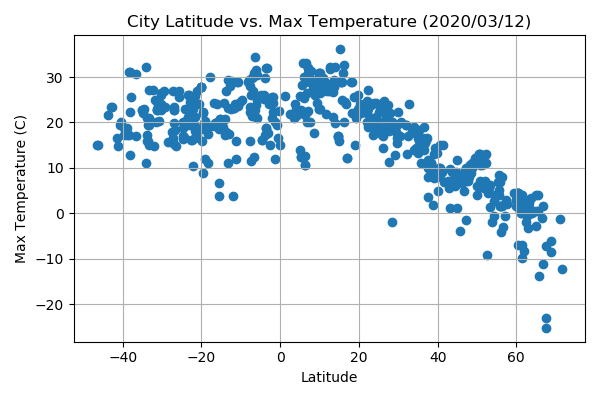

In [235]:
plt.figure(figsize=(6,4))

plt.title(f"City Latitude vs. Max Temperature ({date_str})")

plt.scatter(sample_cities_df['Lat'], sample_cities_df['Max Temp'])
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (C)')
plt.grid()

plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_temp.png')

#### Latitude vs. Humidity Plot

<IPython.core.display.Javascript object>


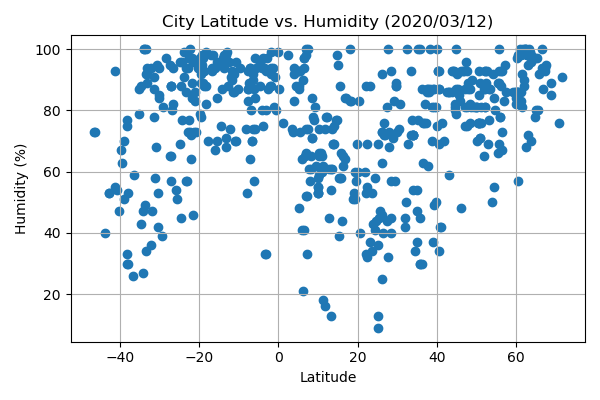

In [236]:
plt.figure(figsize=(6,4))

plt.title(f"City Latitude vs. Humidity ({date_str})")

plt.scatter(sample_cities_df['Lat'], sample_cities_df['Humidity'])
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.grid()

plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_humidity.png')

#### Latitude vs. Cloudiness Plot

<IPython.core.display.Javascript object>


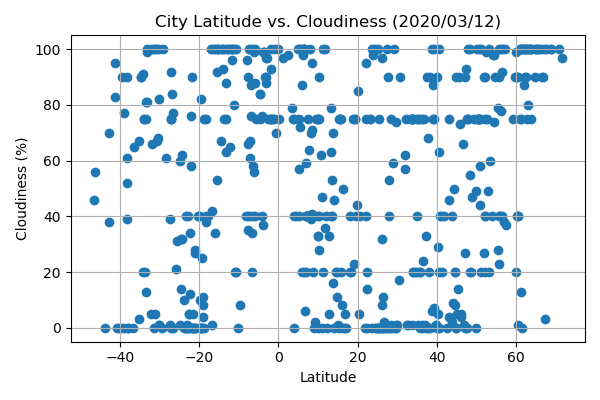

In [237]:
plt.figure(figsize=(6,4))

plt.title(f"City Latitude vs. Cloudiness ({date_str})")

plt.scatter(sample_cities_df['Lat'], sample_cities_df['Cloudiness'])
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.grid()

plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_cloudiness.png')

#### Latitude vs. Wind Speed Plot

<IPython.core.display.Javascript object>


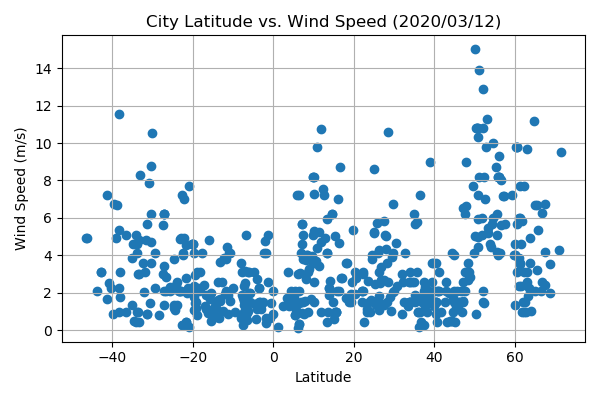

In [238]:
plt.figure(figsize=(6,4))

plt.title(f"City Latitude vs. Wind Speed ({date_str})")

plt.scatter(sample_cities_df['Lat'], sample_cities_df['Wind Speed'])
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (m/s)')
plt.grid()

plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_wind.png')

## Linear Regression

In [193]:
# OPTIONAL: Create a function to create Linear Regression plots
def plot_regression(df, y, y_label, annot_pos_x, annot_pos_y):

    x = 'Latitude'

    (slope, intercept, rvalue, pvalue, stderr) = linregress(df[x], df[y])
    print("The r-squared is: {:.4f}".format(rvalue))

    plt.figure(figsize=(6,4))
    plt.scatter(df[x], df[y])
    plt.xlabel('Latitude')
    plt.ylabel(y_label)
    
    repress_points = [slope * point + intercept for point in df[x]]
    plt.plot(df[x], repress_points, "r-")

    line_eq = "y={:.2f}x{:+.2f}".format(slope, intercept)
    plt.annotate(line_eq, (annot_pos_x, annot_pos_y), fontsize=15, color="red")

    plt.grid()

In [194]:
# Create Northern and Southern Hemisphere DataFrames
northern_hemisphere_df = sample_cities_df.loc[sample_cities_df['Latitude'] > 0, :]
southern_hemisphere_df = sample_cities_df.loc[sample_cities_df['Latitude'] < 0, :]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: -0.8772


<IPython.core.display.Javascript object>


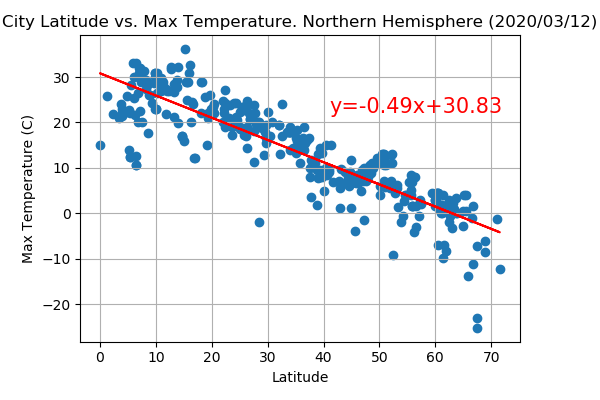

In [239]:
plot_regression(northern_hemisphere_df, 'Max Temp', 'Max Temperature (C)', 41, 22)
plt.title(f"City Latitude vs. Max Temperature. Northern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_temp_north_regr.png')

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.1419


<IPython.core.display.Javascript object>


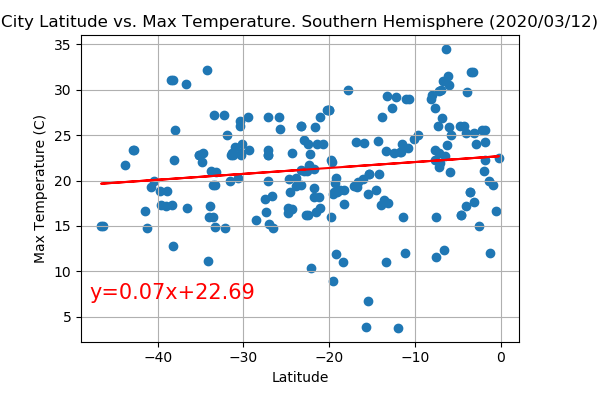

In [240]:
plot_regression(southern_hemisphere_df, 'Max Temp', 'Max Temperature (C)', -48, 7)
plt.title(f"City Latitude vs. Max Temperature. Southern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_temp_south_regr.png')

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.4028


<IPython.core.display.Javascript object>


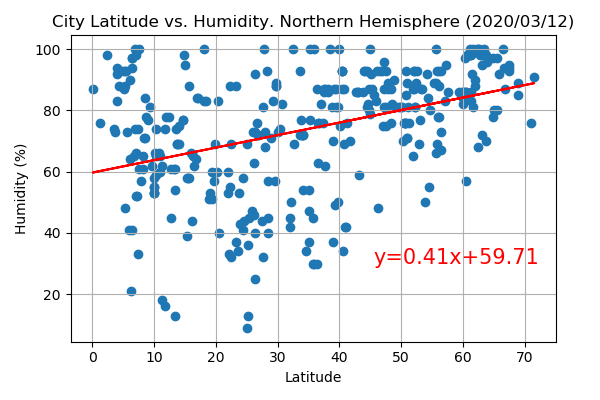

In [241]:
plot_regression(northern_hemisphere_df, 'Humidity', 'Humidity (%)', 45.5, 30)
plt.title(f"City Latitude vs. Humidity. Northern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_humidity_north_regr.png')

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.4078


<IPython.core.display.Javascript object>


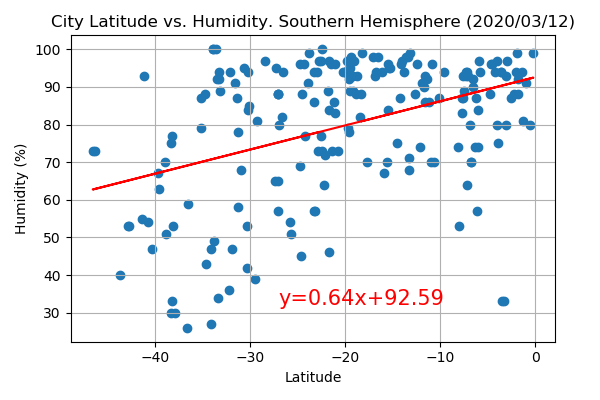

In [242]:
plot_regression(southern_hemisphere_df, 'Humidity', 'Humidity (%)', -27, 32)
plt.title(f"City Latitude vs. Humidity. Southern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_humidity_south_regr.png')

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.2481


<IPython.core.display.Javascript object>


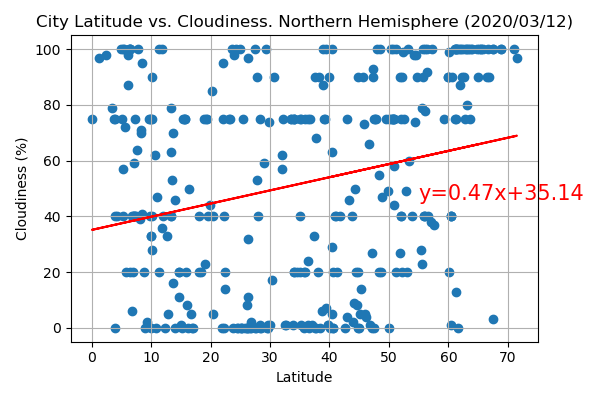

In [243]:
plot_regression(northern_hemisphere_df, 'Cloudiness', 'Cloudiness (%)', 55, 46)
plt.title(f"City Latitude vs. Cloudiness. Northern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_cloudiness_north_regr.png')

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.3047


<IPython.core.display.Javascript object>


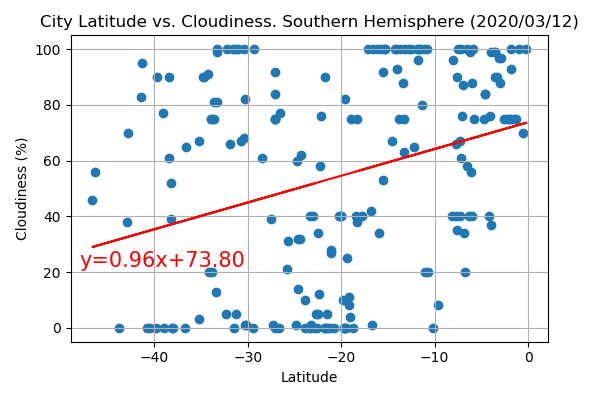

In [244]:
plot_regression(southern_hemisphere_df, 'Cloudiness', 'Cloudiness (%)', -48, 22)
plt.title(f"City Latitude vs. Cloudiness. Southern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_cloudiness_south_regr.png')

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.2711


<IPython.core.display.Javascript object>


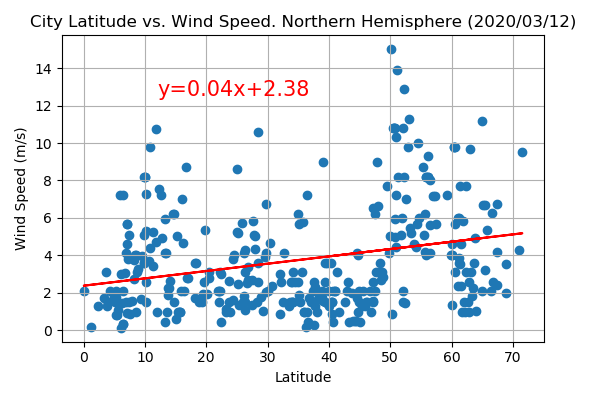

In [245]:
plot_regression(northern_hemisphere_df, 'Wind Speed', 'Wind Speed (m/s)', 12, 12.5)
plt.title(f"City Latitude vs. Wind Speed. Northern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_wind_north_regr.png')

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: -0.3458


<IPython.core.display.Javascript object>


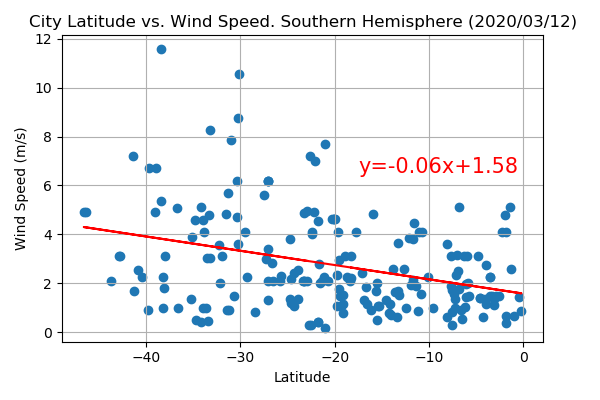

In [246]:
plot_regression(southern_hemisphere_df, 'Wind Speed', 'Wind Speed (m/s)', -17.5, 6.5)
plt.title(f"City Latitude vs. Wind Speed. Southern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_wind_south_regr.png')